## Sample Rate and Extraction Interval Impact Assessment

---

### Objective:

- To assess the impact of different sample rates on the performance of the model and how this is affected by the extraction interval.
- To determine the optimal sample rate and interval for the model features extraction.

### Methodology:

- A model (RF, SVM, LR) is trained with different features (Chroma, MFCC_30, MFCC_120, CQT_30, CQT_70), sample rates (mixed, 4000) and extraction intervals (0.5s, 1s, 2s, 3s). The features are used 'as extracted' without any additional processing.
- The model is trained with 80% of the data and tested with the remaining 20%.

#### Findings:

- No clear advantage of using a mix of frequencies over a fixed sample rate. Actually, a fixed sample rate of 4000Hz lead to a lower risk of bias introduction, to a better efficiency and allows to the usage of a larger variety of features.
- As regard the interval the situation is more complex, because the extraction interval has a direct impact of the number of samples and consequently on the class distribution as shown by the apposite figure. To take into consideration the high imbalance we used macro F1 score and MCC as metrics. In both cases the best results are obtained with 2s interval, however we also have to take into consideration the reduction into the number of samples that this choice implies. This may lead to problems both during training and testing, especially with the most complex models. As a compromise we suggest to use 1s interval, that allows to have a good balance between the number of samples and the class distribution.


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, balanced_accuracy_score

from sklearn.svm import SVC
import tqdm.notebook as tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-paper")
import seaborn as sns

sns.set_theme(context="paper", font_scale=1)

### Set the Paths


In [30]:
# set the paths
BASE_DIR = "../../dataset/"
LABELS = BASE_DIR + "labels.csv"

# features
FEATURES_BASE = "../../features/"
FEATURES = FEATURES_BASE + "raw/"

# Models
MODELS = "../../models/"
MODELS_RESULTS = MODELS + "results/"

# report
PAPER = "../../paper/"
IMAGES_PATH = PAPER + "images_mix/"

# HYERPARAMETERS
SEED = 42
INTERVAL = 2  # 0.5, 1, 2, 3
METRIC = "macrof1"  # 'acc', 'microf1', 'macrof1', 'mcc'

### Load the Data and Train the Model


In [15]:
SEED = 42
full_data_dict_keys = ["artifacts", "extrahls", "murmurs", "normals", "extrastoles"]
interval = INTERVAL
sample_rates = [ 4000]
num_feats = [30, 120, 12, 30, 70]
type_ = ["mfcc", "mfcc", "chroma", "cqt", "cqt"]

# dataframe where to store the results
results_rf = pd.DataFrame(
    columns=["mfcc_30", "mfcc_120", "chroma_12", "cqt_30", "cqt_70"],
    index=["mix", "4000"],
)
results_svm = pd.DataFrame(
    columns=["mfcc_30", "mfcc_120", "chroma_12", "cqt_30", "cqt_70"],
    index=["mix", "4000"],
)
results_lr = pd.DataFrame(
    columns=["mfcc_30", "mfcc_120", "chroma_12", "cqt_30", "cqt_70"],
    index=["mix", "4000"],
)

for sample_rate in sample_rates:
    for i, num_feat in enumerate(num_feats):
        print(f"Processing {sample_rate}hz_{num_feat}{type_[i]}\n")

        # define the features name and load the data
        FEATURES_NAME = (
            f"full_data_{interval}s_{sample_rate}hz_{num_feat}{type_[i]}.npy"
        )
        full_data = np.load(FEATURES + FEATURES_NAME, allow_pickle=True).item()

        # extract the data from the dict
        data_list = []
        for key in full_data_dict_keys:
            X = full_data[key]["X"]
            y = full_data[key]["y"]
            data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
            data_list.append(data)
        full_data_array = np.concatenate(data_list, axis=0)

        # split the data into train and test
        X = full_data_array[:, :-1]
        y = full_data_array[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=SEED
        )

        print("Training random forest\n")
        # train the RF model
        clf = RandomForestClassifier(random_state=SEED)
        clf.fit(X_train, y_train)

        # evaluate the model

        if METRIC == "macrof1":
            y_pred = clf.predict(X_test)
            score = f1_score(y_test, y_pred, average="macro")
        elif METRIC == "microf1":
            y_pred = clf.predict(X_test)
            score = f1_score(y_test, y_pred, average="micro")
        elif METRIC == "acc":
            score = clf.score(X_test, y_test)
        elif METRIC == "mcc":
            y_pred = clf.predict(X_test)
            score = matthews_corrcoef(y_test, y_pred)

        # store the results
        results_rf.iloc[sample_rates.index(sample_rate), i] = score

        print("Training SVM\n")
        # train the SVM
        clf = SVC(random_state=SEED)
        clf.fit(X_train, y_train)

        # evaluate the model
        if METRIC == "macrof1":
            y_pred = clf.predict(X_test)
            score = f1_score(y_test, y_pred, average="macro")
        elif METRIC == "microf1":
            y_pred = clf.predict(X_test)
            score = f1_score(y_test, y_pred, average="micro")
        elif METRIC == "acc":
            score = clf.score(X_test, y_test)
        elif METRIC == "mcc":
            y_pred = clf.predict(X_test)
            score = matthews_corrcoef(y_test, y_pred)

        # store the results
        results_svm.iloc[sample_rates.index(sample_rate), i] = score

        print("Training logistic regression\n")
        # train the LR
        clf = LogisticRegression(random_state=SEED, max_iter=300)
        clf.fit(X_train, y_train)

        # evaluate the model
        if METRIC == "macrof1":
            y_pred = clf.predict(X_test)
            score = f1_score(y_test, y_pred, average="macro")
        elif METRIC == "microf1":
            y_pred = clf.predict(X_test)
            score = f1_score(y_test, y_pred, average="micro")
        elif METRIC == "acc":
            score = clf.score(X_test, y_test)
        elif METRIC == "mcc":
            y_pred = clf.predict(X_test)
            score = matthews_corrcoef(y_test, y_pred)

        # store the results
        results_lr.iloc[sample_rates.index(sample_rate), i] = score


# save the results
results_rf.to_csv(MODELS_RESULTS + f"results_rf_{interval}s_{METRIC}.csv")
results_svm.to_csv(MODELS_RESULTS + f"results_svm_{interval}s_{METRIC}.csv")
results_lr.to_csv(MODELS_RESULTS + f"results_lr_{interval}s_{METRIC}.csv")

Processing 4000hz_30mfcc

Training random forest

Training SVM

Training logistic regression



/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Processing 4000hz_120mfcc

Training random forest

Training SVM

Training logistic regression



/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Processing 4000hz_12chroma

Training random forest

Training SVM

Training logistic regression

Processing 4000hz_30cqt

Training random forest

Training SVM

Training logistic regression

Processing 4000hz_70cqt

Training random forest

Training SVM

Training logistic regression



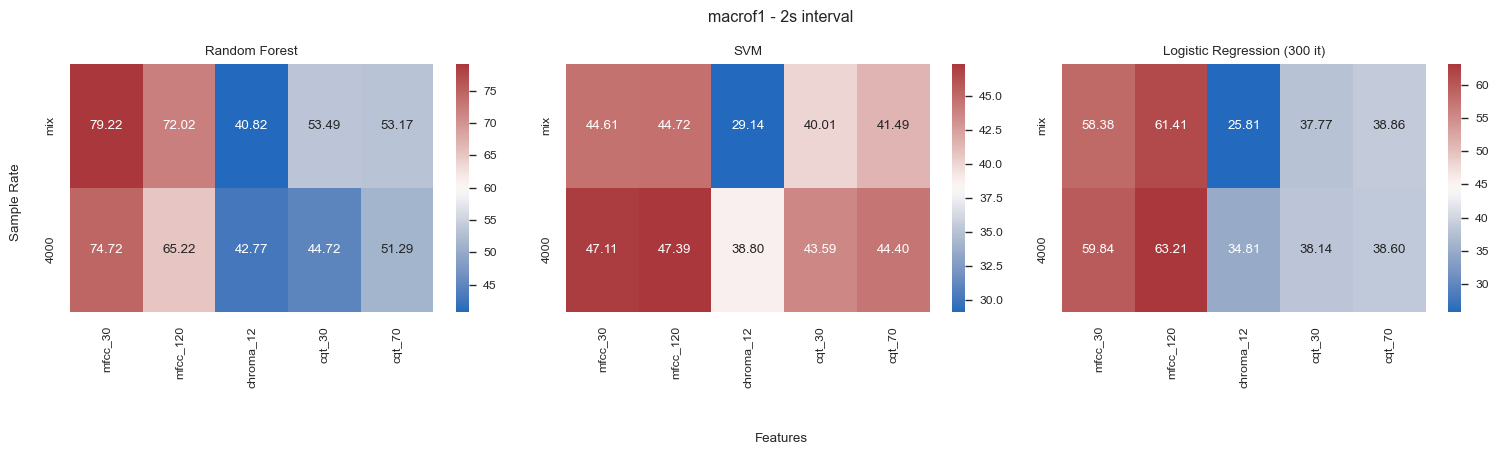

In [16]:
METRIC = 'macrof1'

# load the results
results_rf = pd.read_csv(MODELS_RESULTS + f"results_rf_{INTERVAL}s_{METRIC}.csv", index_col=0)
results_svm = pd.read_csv(MODELS_RESULTS + f"results_svm_{INTERVAL}s_{METRIC}.csv", index_col=0)
results_lr = pd.read_csv(MODELS_RESULTS + f"results_lr_{INTERVAL}s_{METRIC}.csv", index_col=0)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

sns.heatmap(
    results_rf.astype(float) * 100, annot=True, cmap="vlag", fmt=".2f", ax=axs[0]
)
axs[0].set_title("Random Forest")

sns.heatmap(
    results_svm.astype(float) * 100, annot=True, cmap="vlag", fmt=".2f", ax=axs[1]
)
axs[1].set_title("SVM")

sns.heatmap(
    results_lr.astype(float) * 100, annot=True, cmap="vlag", fmt=".2f", ax=axs[2]
)
axs[2].set_title("Logistic Regression (300 it)")

fig.suptitle(f"{METRIC} - {INTERVAL}s interval")
# xlabel and ylabel for entire fig
fig.text(0.5, -0.1, "Features", ha="center")
fig.text(-0.014, 0.5, "Sample Rate", va="center", rotation="vertical")

plt.tight_layout()
plt.show()


# save the figure
fig.savefig(IMAGES_PATH + f"{METRIC}_{INTERVAL}s.png", dpi=300)

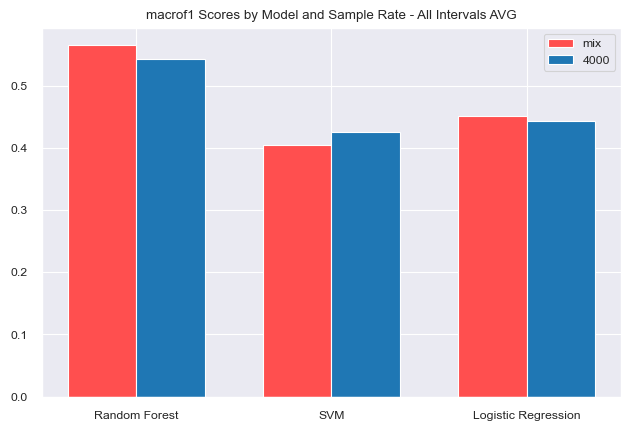

In [37]:
# load the results
sr_mean_lr, sr_mean_rf, sr_mean_svm = [], [], []

for interval in [0.5, 1, 2, 3]:
    #results_rf = pd.read_csv(MODELS_RESULTS + f"results_rf_{interval}s_{METRIC}.csv", index_col=0)
    results_svm = pd.read_csv(MODELS_RESULTS + f"results_svm_{interval}s_{METRIC}.csv", index_col=0)
    results_lr = pd.read_csv(MODELS_RESULTS + f"results_lr_{interval}s_{METRIC}.csv", index_col=0)

    sr_mean_rf.append(results_rf.mean(axis=1))
    sr_mean_svm.append(results_svm.mean(axis=1))
    sr_mean_lr.append(results_lr.mean(axis=1))

sr_mean_rf = pd.DataFrame(sr_mean_rf).mean(axis=0)
sr_mean_svm = pd.DataFrame(sr_mean_svm).mean(axis=0)
sr_mean_lr = pd.DataFrame(sr_mean_lr).mean(axis=0)

df = pd.DataFrame(
    [sr_mean_rf, sr_mean_svm, sr_mean_lr],
    index=["Random Forest", "SVM", "Logistic Regression"],
)
index = df.index

# Define the positions for each set of bars
bar_width = 0.35
x = np.arange(len(index))  # the label locations
x_mix = x - bar_width / 2
x_4000 = x + bar_width / 2

# Plot the data
fig, ax = plt.subplots()
mix = ax.bar(x_mix, df["mix"], bar_width, label="mix", color="#ff4f4f")
_4000 = ax.bar(x_4000, df["4000"], bar_width, label="4000", color="#1f77b4")

# Add labels and legend
#ax.set_ylabel("Scores")
ax.set_title(f"{METRIC} Scores by Model and Sample Rate - All Intervals AVG")
ax.set_xticks(x)
ax.set_xticklabels(index)
ax.legend()
plt.tight_layout()
plt.show()

# save the figure
#fig.savefig(IMAGES_PATH + f"mean_{METRIC}_models_{INTERVAL}s.png", dpi=300)

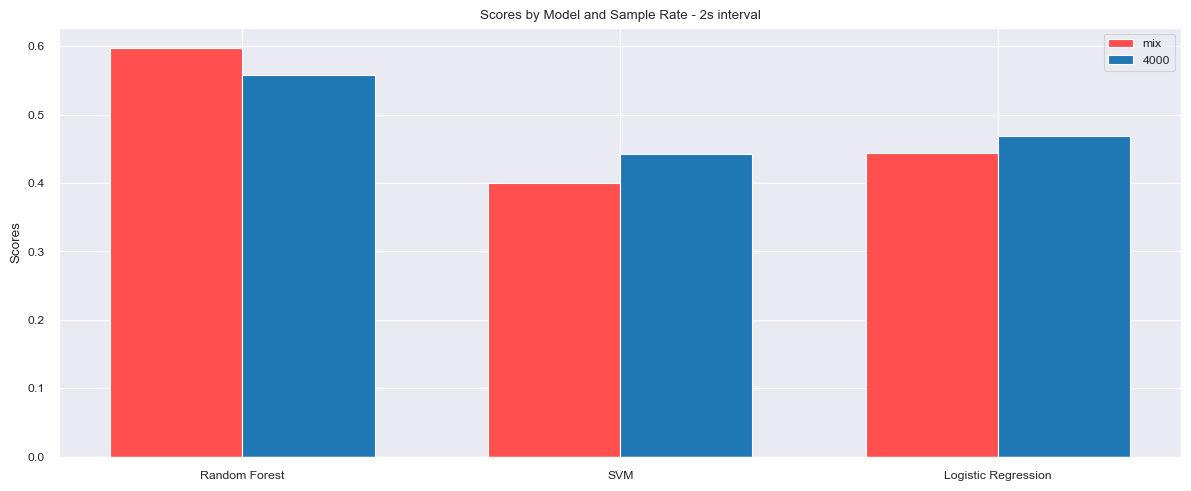

In [26]:
# load the results
results_rf = pd.read_csv(MODELS_RESULTS + f"results_rf_{INTERVAL}s_{METRIC}.csv", index_col=0)
results_svm = pd.read_csv(MODELS_RESULTS + f"results_svm_{INTERVAL}s_{METRIC}.csv", index_col=0)
results_lr = pd.read_csv(MODELS_RESULTS + f"results_lr_{INTERVAL}s_{METRIC}.csv", index_col=0)

sr_mean_rf = results_rf.mean(axis=1)
sr_mean_svm = results_svm.mean(axis=1)
sr_mean_lr = results_lr.mean(axis=1)
df = pd.DataFrame(
    [sr_mean_rf, sr_mean_svm, sr_mean_lr],
    index=["Random Forest", "SVM", "Logistic Regression"],
)
index = df.index

# Define the positions for each set of bars
bar_width = 0.35
x = np.arange(len(index))  # the label locations
x_mix = x - bar_width / 2
x_4000 = x + bar_width / 2

# Plot the data
fig, ax = plt.subplots(figsize=(12, 5))
mix = ax.bar(x_mix, df["mix"], bar_width, label="mix", color="#ff4f4f")
_4000 = ax.bar(x_4000, df["4000"], bar_width, label="4000", color="#1f77b4")

# Add labels and legend
ax.set_ylabel("Scores")
ax.set_title(f"Scores by Model and Sample Rate - {INTERVAL}s interval")
ax.set_xticks(x)
ax.set_xticklabels(index)
ax.legend()
plt.tight_layout()
plt.show()

# save the figure
fig.savefig(IMAGES_PATH + f"mean_{METRIC}_models_{INTERVAL}s.png", dpi=300)

/tmp/ipykernel_10365/2305835697.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_df.loc['mix', str(INTERVAL)] = results_mean_sr[0]
/tmp/ipykernel_10365/2305835697.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_df.loc['4000', str(INTERVAL)] = results_mean_sr[1]
/tmp/ipykernel_10365/2305835697.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_df.loc['mix', str(INTERVAL)] = results_mean_sr[0]
/tmp/ipykern

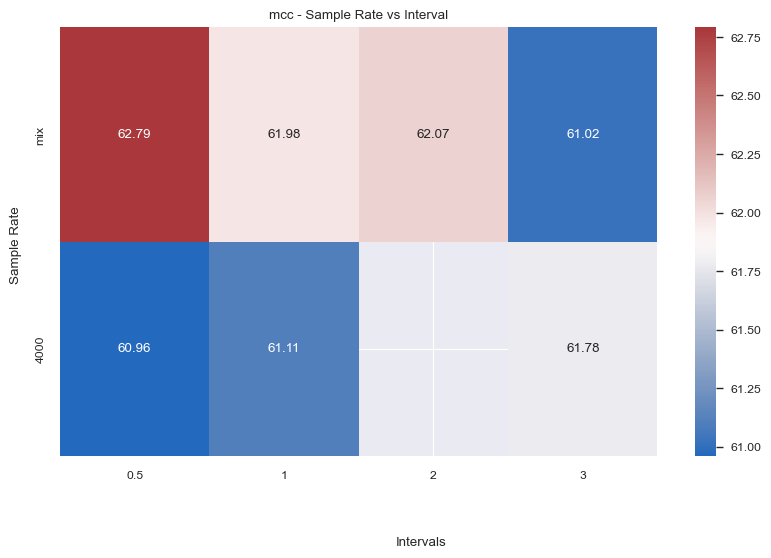

In [55]:
# heatmap having intervals on x and sample rates on y
# load the results
METRIC = 'mcc'
total_df = pd.DataFrame(
    columns=['0.5', '1', '2', '3'],
    index=['mix', '4000']
)
for INTERVAL in [0.5, 1, 2, 3]:
    results_rf = pd.read_csv(MODELS_RESULTS + f"results_rf_{INTERVAL}s_{METRIC}.csv", index_col=0)
    results_svm = pd.read_csv(MODELS_RESULTS + f"results_svm_{INTERVAL}s_{METRIC}.csv", index_col=0)
    results_lr = pd.read_csv(MODELS_RESULTS + f"results_lr_{INTERVAL}s_{METRIC}.csv", index_col=0)

    results_rf_mean_sr = results_rf.mean(axis=1)
    results_svm_mean_sr = results_svm.mean(axis=1)
    results_lr_mean_sr = results_lr.mean(axis=1)
    
    # mean across models
    results_mean_sr = pd.DataFrame([results_rf_mean_sr, results_svm_mean_sr, results_lr_mean_sr]).mean(axis=0)
    
    total_df.loc['mix', str(INTERVAL)] = results_mean_sr[0]
    total_df.loc['4000', str(INTERVAL)] = results_mean_sr[1]

# heatmap
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(total_df.astype(float) * 100, annot=True, cmap="vlag", fmt=".2f", ax=ax)
ax.set_title(f"{METRIC} - Sample Rate vs Interval")
# xlabel and ylabel for entire fig
fig.text(0.5, -0.1, "Intervals", ha="center")
fig.text(-0.014, 0.5, "Sample Rate", va="center", rotation="vertical")
plt.tight_layout()
plt.show()


,0.5,1,2,3
mix,0.48435,0.486574,0.480616,0.471707
4000,0.464367,0.461036,0.489737,0.465484


### Extraction Interval Impact Assessment


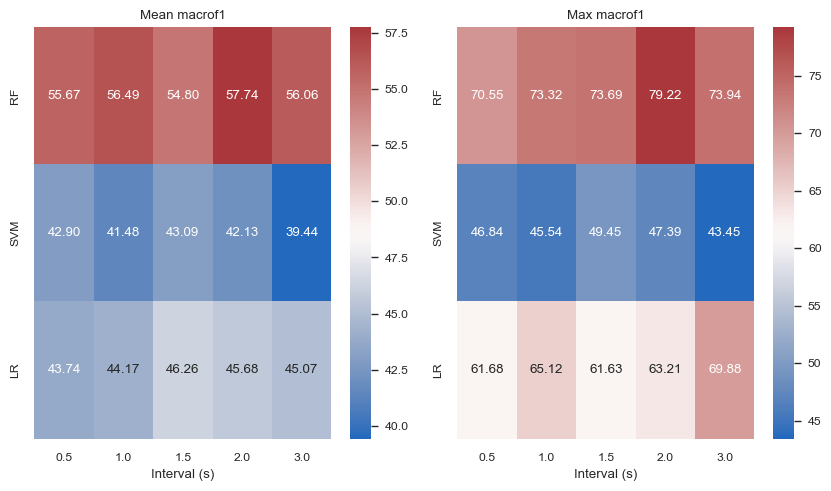

In [6]:
# define dataframe having models as columns and intervals as rows
df_mean = pd.DataFrame(columns=[0.5, 1, 1.5, 2, 3], index=["RF", "SVM", "LR"])
df_max = pd.DataFrame(columns=[0.5, 1, 1.5, 2, 3], index=["RF", "SVM", "LR"])

METRIC = "macrof1"

# load the results
for interval in [0.5, 1, 1.5, 2, 3]:
    results_rf = pd.read_csv(
        MODELS_RESULTS + f"results_rf_{interval}s_{METRIC}.csv", index_col=0
    )
    results_svm = pd.read_csv(
        MODELS_RESULTS + f"results_svm_{interval}s_{METRIC}.csv", index_col=0
    )
    results_lr = pd.read_csv(
        MODELS_RESULTS + f"results_lr_{interval}s_{METRIC}.csv", index_col=0
    )

    # extract mean and max values
    mean_rf = results_rf.mean().mean()
    max_rf = results_rf.max().max()
    mean_svm = results_svm.mean().mean()
    max_svm = results_svm.max().max()
    mean_lr = results_lr.mean().mean()
    max_lr = results_lr.max().max()

    # update the dataframes
    df_mean.iloc[0, df_mean.columns.get_loc(interval)] = mean_rf
    df_mean.iloc[1, df_mean.columns.get_loc(interval)] = mean_svm
    df_mean.iloc[2, df_mean.columns.get_loc(interval)] = mean_lr

    df_max.iloc[0, df_max.columns.get_loc(interval)] = max_rf
    df_max.iloc[1, df_max.columns.get_loc(interval)] = max_svm
    df_max.iloc[2, df_max.columns.get_loc(interval)] = max_lr

# plot the data
fig, axs = plt.subplots(1, 2, figsize=(8.5, 5))

sns.heatmap(df_mean.astype(float) * 100, annot=True, cmap="vlag", fmt=".2f", ax=axs[0])
axs[0].set_title(f"Mean {METRIC}")
axs[0].set_xlabel("Interval (s)")

sns.heatmap(df_max.astype(float) * 100, annot=True, cmap="vlag", fmt=".2f", ax=axs[1])
axs[1].set_title(f"Max {METRIC}")
axs[1].set_xlabel("Interval (s)")

plt.tight_layout()

# fig.suptitle(f"{METRIC} - Interval Impact")

# save
# fig.savefig(IMAGES_PATH + f"{METRIC}_interval_impact.png", dpi=300)

### Investigate number of samples for each extraction interval


In [29]:
# investigate the number of samples for each extraction interval
num_samples = []
full_data_dict_keys = ["artifacts", "extrahls", "murmurs", "normals", "extrastoles"]

for interval in [0.5, 1, 2, 3]:
    FEATURES_NAME = f"full_data_{interval}s_mixhz_30mfcc.npy"
    full_data = np.load(FEATURES + FEATURES_NAME, allow_pickle=True).item()

    data_list = []
    for key in full_data_dict_keys:
        X = full_data[key]["X"]
        y = full_data[key]["y"]
        data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
        data_list.append(data)
    full_data_array = np.concatenate(data_list, axis=0)
    num_samples.append(full_data_array.shape[0])

# plot the data
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x=[0.5, 1, 2, 3], y=num_samples, ax=ax)
ax.set_title("Number of Samples per Interval")
ax.set_xlabel("Interval (s)")
ax.set_ylabel("Number of Samples")

FileNotFoundError: [Errno 2] No such file or directory: '../../features/raw/full_data_1.5s_4000hz_30mfcc.npy'

### Investigate the class distribution for each extraction interval


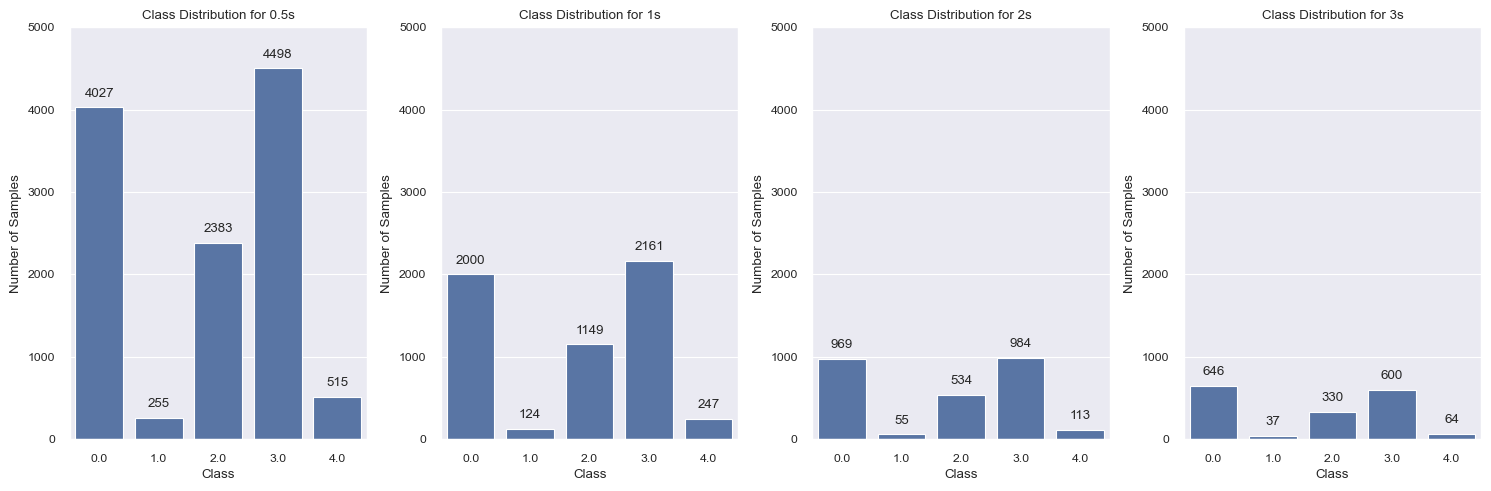

In [ ]:
# investigate the class distribution for each extraction interval
class_distribution = []
import numpy as np

for interval in [0.5, 1, 2, 3]:
    FEATURES_NAME = f"full_data_{interval}s_mixhz_30mfcc.npy"
    full_data = np.load(FEATURES + FEATURES_NAME, allow_pickle=True).item()

    data_list = []
    for key in full_data_dict_keys:
        X = full_data[key]["X"]
        y = full_data[key]["y"]
        data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
        data_list.append(data)
    full_data_array = np.concatenate(data_list, axis=0)
    class_distribution.append(np.unique(full_data_array[:, -1], return_counts=True)[1])

# plot the data
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i, interval in enumerate([0.5, 1, 2, 3]):
    sns.barplot(x=np.unique(full_data_array[:, -1]), y=class_distribution[i], ax=ax[i])
    # min and max set
    ax[i].set_ylim([0, 5000])
    ax[i].set_title(f"Class Distribution for {interval}s")
    ax[i].set_xlabel("Class")
    ax[i].set_ylabel("Number of Samples")
    # add value as int on top of the bars
    for p in ax[i].patches:
        ax[i].annotate(
            f"{int(p.get_height())}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 10),
            textcoords="offset points",
        )

plt.tight_layout()

fig.savefig(IMAGES_PATH + "class_distribution.png", dpi=300)

<Axes: >

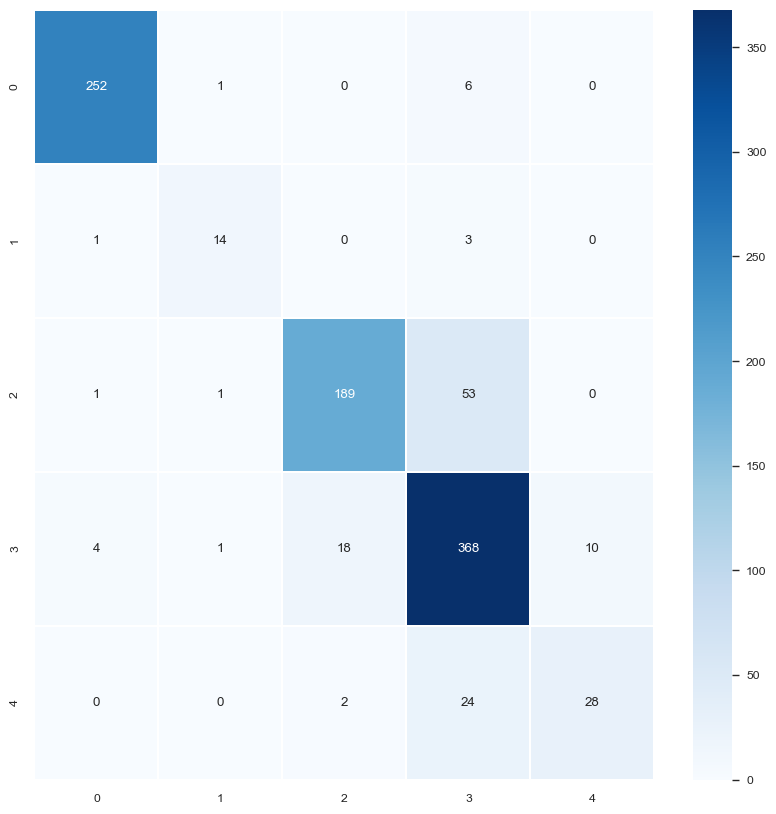

In [8]:
# import confusion matrix
from sklearn.metrics import confusion_matrix


INTERVAL = 1.5

RESULT_NAME = "results_balancing_comparison_macrof1_train.csv"
BALANCING_TYPE = "none"
COMPLETE_DATA_PRIOR_CORR_NAME = f"full_data_{BALANCING_TYPE}_bal_{INTERVAL}s_4000hz_30mfcc_12chroma_70cqt_41rms_41zcr_41sc_61sb_41sr_FILENAME.npy"


# load the data
full_data = np.load(FEATURES + COMPLETE_DATA_PRIOR_CORR_NAME, allow_pickle=True).item()

full_data.keys()

# ----------------------------------------- Create DataFrame to store results-----------------------------------------


# ----------------------------------------- Loop over each feature-----------------------------------------

# Extract data from the dictionary
X_train = full_data["train"]["X"]
y_train = full_data["train"]["y"]
X_test = full_data["test"]["X"]
y_test = full_data["test"]["y"]

clf = RandomForestClassifier(random_state=SEED)
# fit the model
clf.fit(X_train, y_train)

cm=confusion_matrix(y_test, clf.predict(X_test))
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d",linewidths=0.05 ,cmap="Blues", ax=ax)



<Axes: >

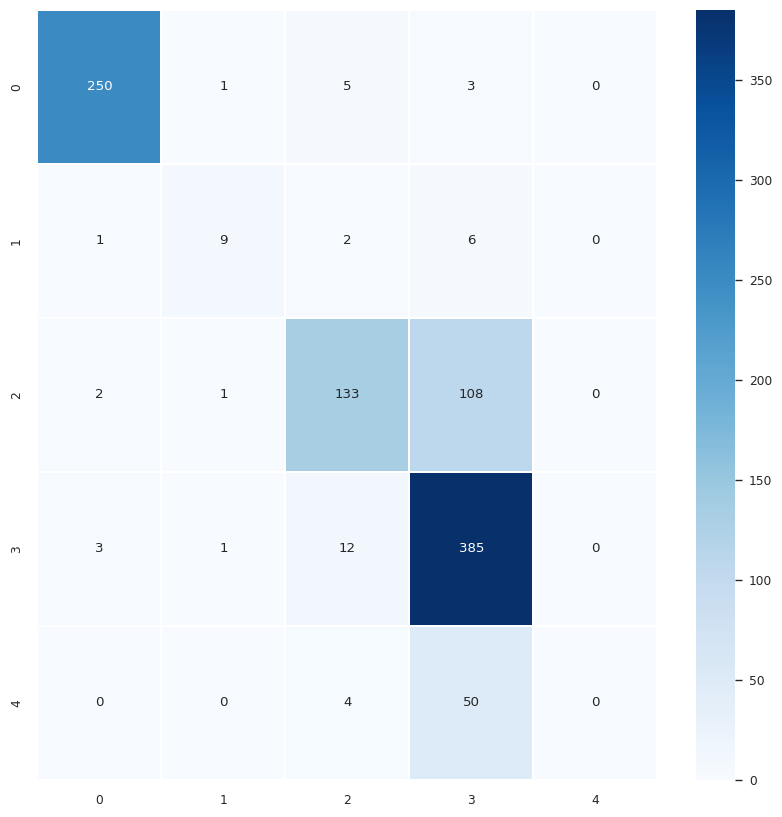

In [36]:
# import confusion matrix
from sklearn.metrics import confusion_matrix


INTERVAL = 1

RESULT_NAME = "results_balancing_comparison_macrof1_train.csv"
BALANCING_TYPE = "none"
COMPLETE_DATA_PRIOR_CORR_NAME = f"full_data_{BALANCING_TYPE}_bal_{INTERVAL}s_4000hz_30mfcc_12chroma_70cqt_41rms_41zcr_41sc_61sb_41sr_FILENAME.npy"


# load the data
full_data = np.load(FEATURES + COMPLETE_DATA_PRIOR_CORR_NAME, allow_pickle=True).item()

full_data.keys()

# ----------------------------------------- Create DataFrame to store results-----------------------------------------


# ----------------------------------------- Loop over each feature-----------------------------------------

# Extract data from the dictionary
X_train = full_data["train"]["X"]
y_train = full_data["train"]["y"]
X_test = full_data["test"]["X"]
y_test = full_data["test"]["y"]

clf = RandomForestClassifier(random_state=SEED)
# fit the model
clf.fit(X_train, y_train)

cm=confusion_matrix(y_test, clf.predict(X_test))
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d",linewidths=0.05 ,cmap="Blues", ax=ax)



<Axes: >

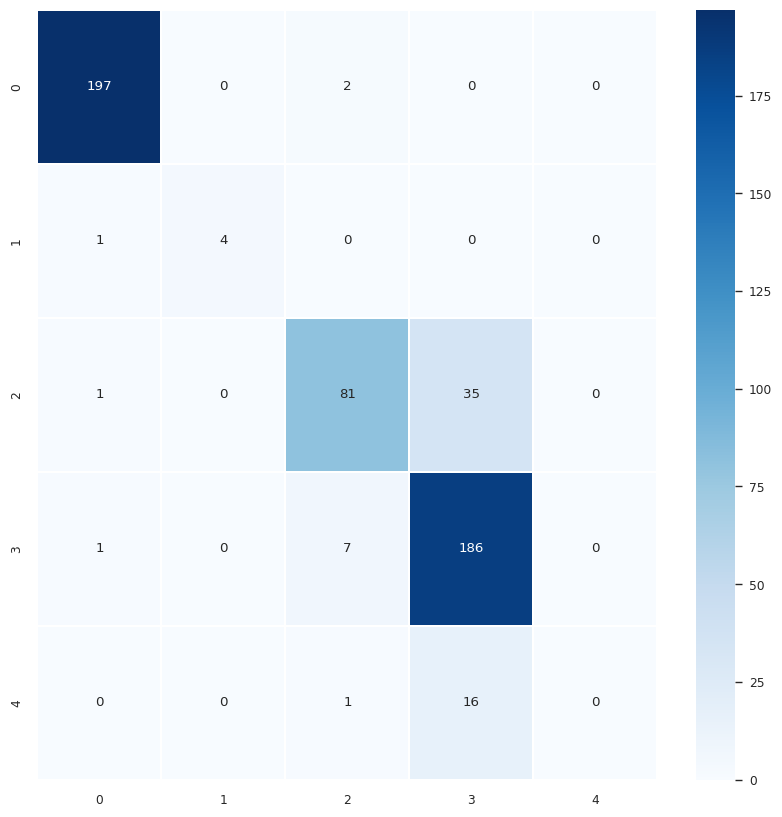

In [37]:
# import confusion matrix
from sklearn.metrics import confusion_matrix


INTERVAL = 2

RESULT_NAME = "results_balancing_comparison_macrof1_train.csv"
BALANCING_TYPE = "none"
COMPLETE_DATA_PRIOR_CORR_NAME = f"full_data_{BALANCING_TYPE}_bal_{INTERVAL}s_4000hz_30mfcc_12chroma_70cqt_41rms_41zcr_41sc_61sb_41sr.npy"


# load the data
full_data = np.load(FEATURES + COMPLETE_DATA_PRIOR_CORR_NAME, allow_pickle=True).item()

full_data.keys()

# ----------------------------------------- Create DataFrame to store results-----------------------------------------


# ----------------------------------------- Loop over each feature-----------------------------------------

# Extract data from the dictionary
X_train = full_data["train"]["X"]
y_train = full_data["train"]["y"]
X_test = full_data["test"]["X"]
y_test = full_data["test"]["y"]

clf = RandomForestClassifier(random_state=SEED)
# fit the model
clf.fit(X_train, y_train)

cm=confusion_matrix(y_test, clf.predict(X_test))
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d",linewidths=0.05 ,cmap="Blues", ax=ax)

